In [1]:
%pip install neattext

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import regex as re
from sklearn.base import TransformerMixin
from neattext.pattern_data.pattern_data import STOPWORDS_en
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### Data Reading and Exploration

In [3]:
PATH = ''

In [4]:
df_fake = pd.read_csv(PATH+"Fake.csv")
df_true = pd.read_csv(PATH+"True.csv")

df_fake = df_fake.drop(columns=['title','subject','date'])
df_true = df_true.drop(columns=['title','subject','date'])

In [5]:
df_true = df_true.dropna()
df_fake = df_fake.dropna()
df_fake['Fake'] = 1
df_true['Fake'] = 0

### Data Visulaization

There are 59838891 words in the combination of all review.


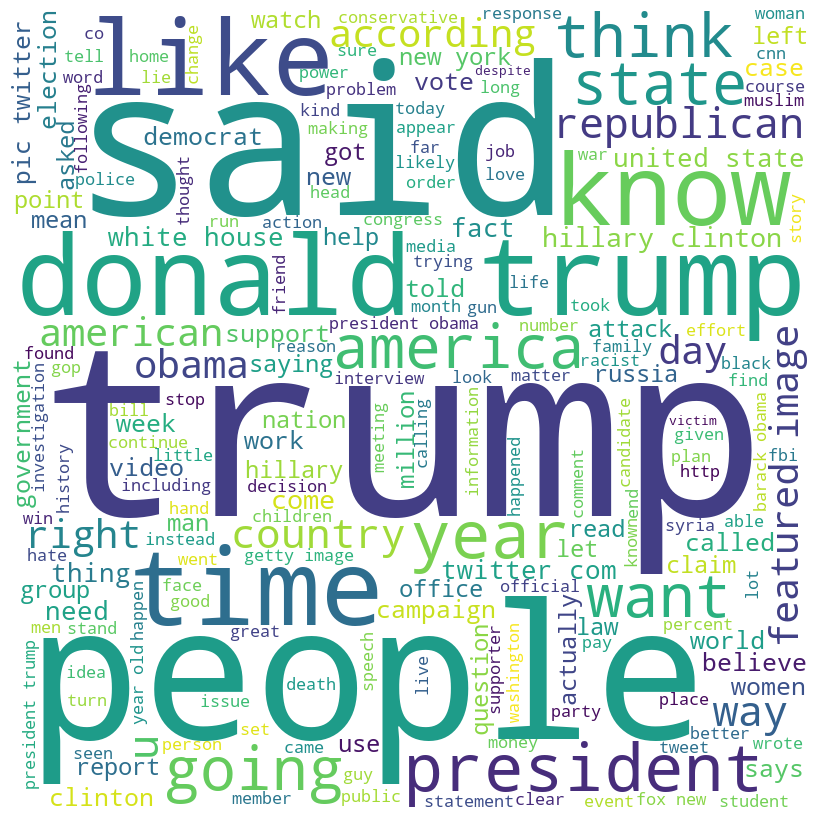

In [6]:
stopwords = set(STOPWORDS)
stopwords = set(STOPWORDS_en)
    
fake_words = " ".join(text.lower() for text in df_fake.text)
print ("There are {} words in the combination of all review.".format(len(fake_words)))    

fake_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(fake_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(fake_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

There are 51064092 words in the combination of all review.


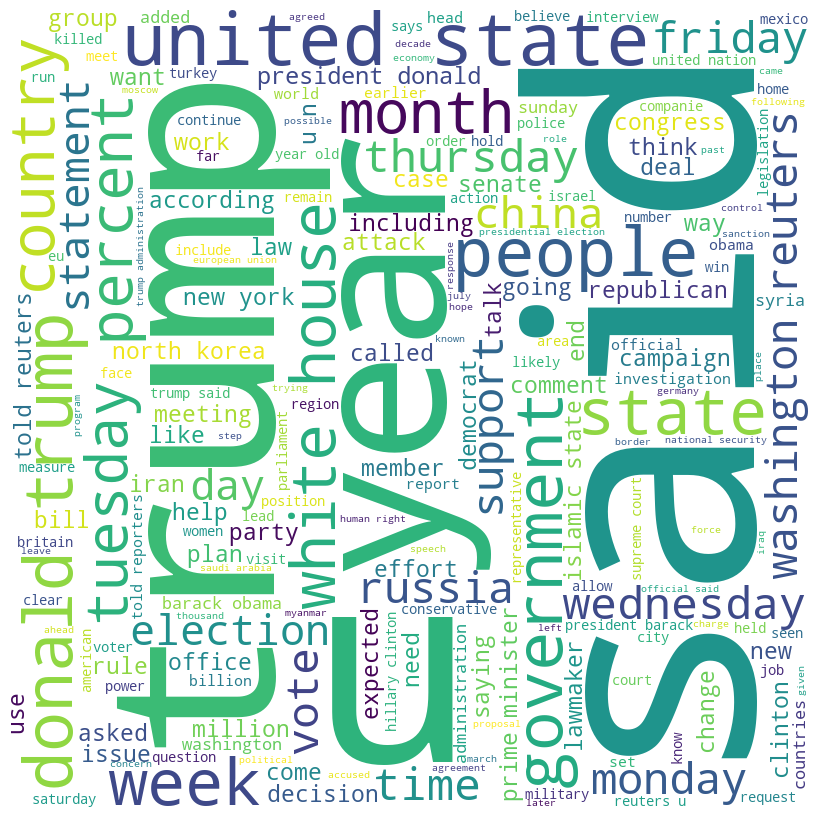

In [7]:
true_words = " ".join(text.lower() for text in df_true.text)
print ("There are {} words in the combination of all review.".format(len(true_words))) 

true_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(true_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(true_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [8]:
df = pd.concat([df_fake, df_true], axis=0, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.isna().sum()

text    0
Fake    0
dtype: int64

### Text PreProcessing

In [9]:
import nltk
import neattext.functions as nfx
from pandas.core.frame import DataFrame

class DataPreProcessor():
    def __init__(self) -> None:
        # Veri ve temizlenmiş veriyi depolamak için değişkenler
        self.data = None 
        self.cleand_data = None

        # Kelime havuzu için bir kümeye sahip olmak için
        self.word_pool: set[str] = set()

    # Veriyi temizleme metodu
    def first_cleaning_data(self, data: DataFrame) -> DataFrame:
    # NLTK kütüphanesinden bazı araçları indirme
        nltk.download('stopwords')
        nltk.download('punkt')
        nltk.download('wordnet')

    # Veri setindeki incelemelerin tüm karakterlerini küçük harfe dönüştürme
        data["text"] = data["text"].str.lower()
    # URL'leri kaldırma
        data["text"] = data["text"].apply(nfx.remove_urls)
    # HTML etiketlerini kaldırma
        data["text"] = data["text"].apply(nfx.remove_html_tags)
    # Özel karakterleri kaldırma
        data["text"] = data["text"].apply(nfx.remove_special_characters)
    # Durak kelimelerini kaldırma
        data["text"] = data["text"].apply(nfx.remove_stopwords)

        return data

    # Veri setini okumak için bir metod
    def read_data(self, path = "raw_data.csv"):
        self.data = pd.read_csv(path)
        return self.data

    # Veriyi temizlemek için Ana metod
    def cleaning_data(self, path = "cleaned_data.csv"):
        try:
        # Burda temizlenmiş veriler zaten bir dosyada varsa, bu dosyayı okur
            self.cleaned_data =  pd.read_csv(path)
        except FileNotFoundError as ex:
        # Dosya yoksa, verileri "first_cleaning_data" metodu ile temizleme işlemini gerçekleştir.
            self.cleaned_data = self.first_cleaning_data(self.data)
        # Temizlenmiş verileri bir csv dosyasına kaydetme
            self.cleaned_data.to_csv(path,index=False)
        
        return self.cleaned_data


In [10]:
df.to_csv(PATH+"News.csv", index=False)
cleaner = DataPreProcessor()
cleaner.data = df
# data = cleaner.read_data("News.csv")
cleaned_data = cleaner.cleaning_data(PATH+"cleaned_data.csv")
cleaned_data = cleaned_data.dropna()



### My Logistic Regressor

In [11]:
class LogisticRegrression():

    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def sigmoid(x):
        return 1/(1+np.exp(-x))

    def fit(self, X, y):
        m = X.shape[1]
        n = X.shape[0]
        self.weights = np.zeros(n)
        self.bias = 0
        
        for _ in range(self.n_iters):
            Z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(Z)
            
            # cost function
            # cost = -(1/m)*np.sum( y*np.log(predictions) + (1-y)*np.log(1-predictions))
            
            # Gradient Descent
            dW = (1/m)*np.dot(X.T, predictions-y)
            dB = (1/m)*np.sum(predictions - y)
            
            self.weights = self.weights - self.lr*dW
            self.bias = self.bias - self.lr*dB


    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        class_pred = [0 if y<=0.5 else 1 for y in y_pred]
        return class_pred

In [12]:
df = cleaned_data
X = df['text']  
y = df['Fake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [13]:
lr_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_model', LogisticRegression()),])

lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)



accuracy_score:  0.9885326291965296
Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6379
           1       0.99      0.99      0.99      6876

    accuracy                           0.99     13255
   macro avg       0.99      0.99      0.99     13255
weighted avg       0.99      0.99      0.99     13255



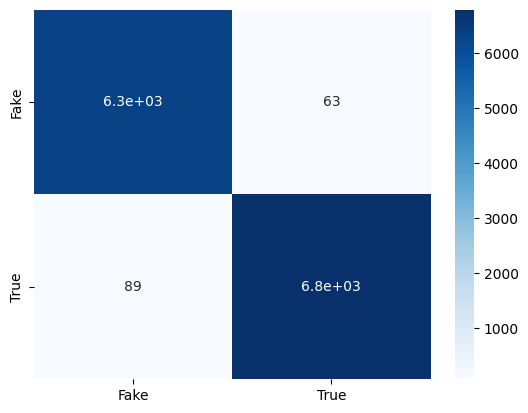

In [14]:
import seaborn as sns
print("accuracy_score: ",metrics.accuracy_score(y_test,y_pred))

print("="*70)

print("Report:")
print(metrics.classification_report(y_test,y_pred))

con_matrix = metrics.confusion_matrix(y_test,y_pred)
# print(con_matrix)
sns.heatmap(con_matrix,annot=True,cmap= 'Blues',xticklabels=['Fake','True'],yticklabels=['Fake','True'])
plt.show()
